<a href="https://colab.research.google.com/github/ShynPham/Face-mask-detection-YOLOv8/blob/main/Face_Mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# 0. Import all necessary library
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# Check ther torch and torchvision version
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Torch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126


# 1. Getting datasets
The datasets we will be using are the Face Mask Dectection Dataset from Kaggle.

We will be download and split between test and train datasets



Now that the Kaggle API is installed, you'll need to set up your credentials to download datasets. Here's how:

1.  **Get your Kaggle API Token**: Go to your Kaggle account settings (`https://www.kaggle.com/<your-username>/account`). Scroll down to the "API" section and click "Create New API Token". This will download a `kaggle.json` file to your computer.
2.  **Upload `kaggle.json` to Colab**: In the left sidebar of your Colab notebook, click on the folder icon to open the file browser. Click the "Upload to session storage" icon and upload the `kaggle.json` file you just downloaded.
3.  **Move the file to the correct directory**: The Kaggle API expects the `kaggle.json` file to be in the `.kaggle` directory in your home folder. You can use the following commands in a code cell to create the directory and move the file:

In [78]:

# Download the dataset
!kaggle datasets download -d andrewmvd/face-mask-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
License(s): CC0-1.0
face-mask-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [52]:
# unzip the file and deleted the zip file
import zipfile
with zipfile.ZipFile("face-mask-detection.zip", "r") as zip_ref:
    zip_ref.extractall()
    zip_ref.close()

!rm -rf face-mask-detection.zip

# 2. Split images and annotations  into train and test datasets
Since the images folder contain everything, we will have to make a function to split the images folder into two train and test datasets

Become one with the data



In [53]:
# Create directory
from pathlib import Path
import os

dataset_dir = Path("dataset")
train_dir = dataset_dir / "train"
test_dir = dataset_dir / "test"

train_images_dir = train_dir / "images"
train_annotations_dir = train_dir / "annotations"
test_images_dir = test_dir / "images"
test_annotations_dir = test_dir / "annotations"

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_annotations_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_annotations_dir, exist_ok=True)

print("Directory structure created successfully.")

Directory structure created successfully.


In [54]:
import os

dataset_kaggle_path = "/kaggle/input/face-mask-detection"
image_kaggle_path = os.path.join(dataset_kaggle_path, "images")
annotation_kaggle_path = os.path.join(dataset_kaggle_path, "annotations")


image_files = [f for f in os.listdir(image_kaggle_path) if f.endswith(".png")]
annotation_files = [f for f in os.listdir(annotation_kaggle_path) if f.endswith(".xml")]

print(f"Number of image files: {len(image_files)}")
print(f"Number of annotation files: {len(annotation_files)}")

Number of image files: 853
Number of annotation files: 853


In [55]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_annotations, test_annotations = train_test_split(
    image_files, annotation_files, test_size=0.2, random_state=42
)

print(f"Number of training images: {len(train_images)}")
print(f"Number of testing images: {len(test_images)}")
print(f"Number of training annotations: {len(train_annotations)}")
print(f"Number of testing annotations: {len(test_annotations)}")

Number of training images: 682
Number of testing images: 171
Number of training annotations: 682
Number of testing annotations: 171


In [56]:
import shutil
import os

# Define the directories
dataset_dir = Path("dataset")
train_dir = dataset_dir / "train"
test_dir = dataset_dir / "test"

train_images_dir = train_dir / "images"
train_annotations_dir = train_dir / "annotations"
test_images_dir = test_dir / "images"
test_annotations_dir = test_dir / "annotations"

# Remove existing train and test directories to ensure a clean copy
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
    print(f"Removed existing directory: {train_dir}")
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    print(f"Removed existing directory: {test_dir}")

# Recreate directories
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_annotations_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_annotations_dir, exist_ok=True)
print("Directory structure recreated.")

def copy_files(file_list, source_dir, destination_dir):
    """Copies files from a source directory to a destination directory."""
    copied_files = []
    for file_name in file_list:
        source_path = os.path.join(source_dir, file_name)
        destination_path = os.path.join(destination_dir, file_name)
        try:
            shutil.copy(source_path, destination_path)
            copied_files.append(file_name)
        except FileNotFoundError:
            print(f"Warning: Source file not found: {source_path}")
        except Exception as e:
            print(f"Error copying file {source_path} to {destination_path}: {e}")
    return copied_files

# Define the correct source directories
dataset_kaggle_path = "/kaggle/input/face-mask-detection"
image_kaggle_path = os.path.join(dataset_kaggle_path, "images")
annotation_kaggle_path = os.path.join(dataset_kaggle_path, "annotations")


# Copy training annotations first
copied_train_annotations = copy_files(train_annotations, annotation_kaggle_path, train_annotations_dir)
# Copy corresponding training images
train_image_filenames_to_copy = [os.path.splitext(ann)[0] + ".png" for ann in copied_train_annotations]
copied_train_images = copy_files(train_image_filenames_to_copy, image_kaggle_path, train_images_dir)


# Copy testing annotations first
copied_test_annotations = copy_files(test_annotations, annotation_kaggle_path, test_annotations_dir)
# Copy corresponding testing images
test_image_filenames_to_copy = [os.path.splitext(ann)[0] + ".png" for ann in copied_test_annotations]
copied_test_images = copy_files(test_image_filenames_to_copy, image_kaggle_path, test_images_dir)


print("Files copied to train and test directories successfully.")

# Verification step: Check if all files from the lists were actually copied
print("\nVerification:")
print(f"Attempted to copy {len(train_images)} training images, successfully copied {len(copied_train_images)}")
print(f"Attempted to copy {len(train_annotations)} training annotations, successfully copied {len(copied_train_annotations)}")
print(f"Attempted to copy {len(test_images)} testing images, successfully copied {len(copied_test_images)}")
print(f"Attempted to copy {len(test_annotations)} testing annotations, successfully copied {len(copied_test_annotations)}")

# Identify missing files if any
missing_train_annotations = set(train_annotations) - set(copied_train_annotations)
if missing_train_annotations:
    print(f"\nMissing training annotation files: {missing_train_annotations}")

missing_test_annotations = set(test_annotations) - set(copied_test_annotations)
if missing_test_annotations:
    print(f"Missing testing annotation files: {missing_test_annotations}")

missing_train_images = set(train_image_filenames_to_copy) - set(copied_train_images)
if missing_train_images:
    print(f"\nMissing training image files: {missing_train_images}")

missing_test_images = set(test_image_filenames_to_copy) - set(copied_test_images)
if missing_test_images:
    print(f"Missing testing image files: {missing_test_images}")

Removed existing directory: dataset/train
Removed existing directory: dataset/test
Directory structure recreated.
Files copied to train and test directories successfully.

Verification:
Attempted to copy 682 training images, successfully copied 682
Attempted to copy 682 training annotations, successfully copied 682
Attempted to copy 171 testing images, successfully copied 171
Attempted to copy 171 testing annotations, successfully copied 171


# 2.1 Visualize a random images and its annotation within train dataset

Image size: (400, 272)


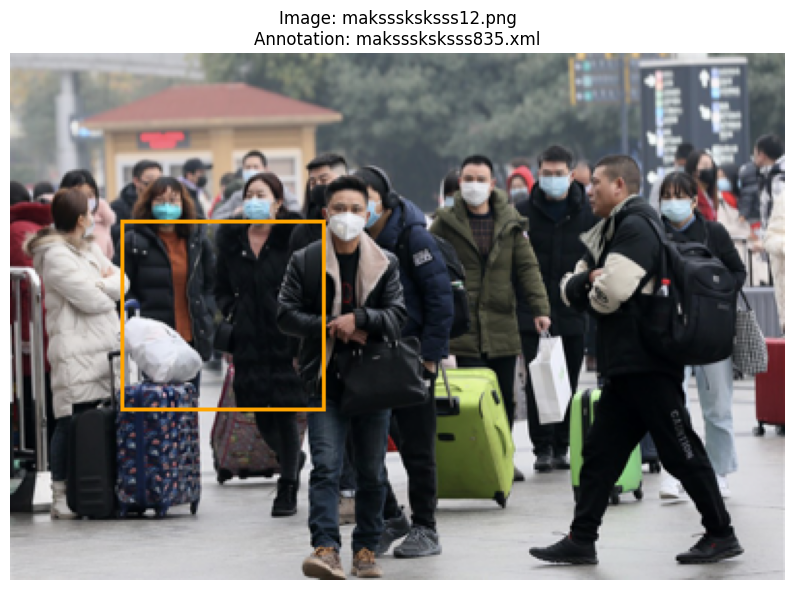

In [57]:
import os
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import random

# Get a random index
random_index = random.randint(0, len(train_images) - 1)

# Get the random training image and annotation filenames
image_filename = train_images[random_index]
annotation_filename = train_annotations[random_index]

# Construct the full paths
image_path = os.path.join(train_images_dir, image_filename)
annotation_path = os.path.join(train_annotations_dir, annotation_filename)

# Load the image
image = Image.open(image_path).convert("RGB")

# Parse the XML annotation file
tree = ET.parse(annotation_path)
root = tree.getroot()

# Get image size
size = root.find('size')
width = int(size.find('width').text)
height = int(size.find('height').text)

# Create a drawing object
draw = ImageDraw.Draw(image)

# Iterate over objects and draw bounding boxes
for obj in root.findall('object'):
    label = obj.find('name').text
    bndbox = obj.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    # Define color based on label (example colors, you can customize)
    color = "red"  # Default color
    if label == "with_mask":
        color = "green"
    elif label == "without_mask":
        color = "red"
    elif label == "mask_weared_incorrect":
        color = "orange"

    # Draw the bounding box
    draw.rectangle([(xmin, ymin), (xmax, ymax)], outline=color, width=2)


# Display the image
print(f"Image size: {image.size}")
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.title(f"Image: {image_filename}\nAnnotation: {annotation_filename}")
plt.show()

# 3. Transform image

### 3.1 Create a custom dataset class

We'll create a custom dataset class `FaceMaskDataset` that inherits from `torch.utils.data.Dataset`. This class will handle loading images, parsing annotations, and applying transformations.

In [58]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import functional as F

class FaceMaskDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        # Store tuples of (image_filename, annotation_filename)
        self.file_pairs = []
        image_filenames = [f for f in os.listdir(image_dir) if f.endswith(".png")]
        annotation_filenames = [f for f in os.listdir(annotation_dir) if f.endswith(".xml")]

        # Create a dictionary for quick lookup of annotation filenames by image filename (without extension)
        annotation_dict = {os.path.splitext(f)[0]: f for f in annotation_filenames}

        for img_filename in image_filenames:
            base_filename = os.path.splitext(img_filename)[0]
            if base_filename in annotation_dict:
                self.file_pairs.append((img_filename, annotation_dict[base_filename]))
            else:
                print(f"Warning: No annotation found for image: {img_filename}")

    def __len__(self):
        return len(self.file_pairs)

    def __getitem__(self, idx):
        img_filename, annotation_filename = self.file_pairs[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        annotation_path = os.path.join(self.annotation_dir, annotation_filename)

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Parse annotation
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Convert labels to integers (you'll need to define a mapping from string labels to integers)
        label_map = {"without_mask": 0, "with_mask": 1, "mask_weared_incorrect": 2}
        # Handle cases where a label might not be in the map
        int_labels = []
        for label in labels:
            if label in label_map:
                int_labels.append(label_map[label])
            else:
                print(f"Warning: Unknown label '{label}' found. Skipping.")
        labels = torch.as_tensor(int_labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)


        if self.transform:
            image, target = self.transform(image, target)


        return image, target



### 3.2 Implement custom transformations for images and bounding boxes

Since `torchvision.transforms` primarily works on images, we'll create custom transform classes that apply transformations to both the image and update the bounding box coordinates accordingly.

In [59]:
import torchvision
import random
from torchvision.transforms import functional as F

class Compose:
    """Composes several transforms together."""
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor:
    """Converts a PIL Image and the target (including bounding boxes) to tensors."""
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class RandomHorizontalFlip:
    """Randomly flips the image horizontally and flips the bounding boxes."""
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            # Get image size from the image tensor
            # The image is a tensor at this point, so use its shape
            height, width = image.shape[-2:]
            image = F.hflip(image)
            bbox = target["boxes"]
            # Ensure bounding boxes are on the same device as the image
            bbox = bbox.to(image.device)
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]] # Flip xmin and xmax
            target["boxes"] = bbox
        return image, target

class Resize:
    """Resizes the image and adjusts the bounding boxes."""
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        # Get image size from the image tensor
        # The image is a tensor at this point, so use its shape
        original_height, original_width = image.shape[-2:]
        image = F.resize(image, self.size)
        new_height, new_width = image.shape[-2:]

        bbox = target["boxes"]
        # Ensure bounding boxes are on the same device as the image
        bbox = bbox.to(image.device)
        bbox[:, [0, 2]] = bbox[:, [0, 2]] * (new_width / original_width)
        bbox[:, [1, 3]] = bbox[:, [1, 3]] * (new_height / original_height)
        target["boxes"] = bbox
        return image, target

class GaussianBlurTransform:
    """Applies Gaussian blur to the image."""
    def __init__(self, kernel_size, sigma):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, image, target):
        # Apply Gaussian blur using functional interface
        image = F.gaussian_blur(image, self.kernel_size, self.sigma)
        return image, target

class Normalize:
    """Normalizes a tensor image with mean and standard deviation."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, target):
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image, target

### 3.3 Define and apply transformations

Now you can define your desired transformations using the custom classes and apply them to your dataset.

In [60]:
# Define your transformations
transform = Compose([
    ToTensor(), # Convert to tensor first
    Resize((224, 224)),
    RandomHorizontalFlip(0.5), # Randomly flip horizontally
    GaussianBlurTransform(kernel_size=(5, 5), sigma=(0.1, 2.0)), # Add blur using the custom transform
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Add normalization
    # Add more transformations as needed
])

# Create the dataset with transformations
# Move dataset initialization after file copying
train_dataset = FaceMaskDataset(train_images_dir, train_annotations_dir, transform=transform)
test_dataset = FaceMaskDataset(test_images_dir, test_annotations_dir, transform=transform)

print(f"Number of samples in training dataset: {len(train_dataset)}")
print(f"Number of samples in testing dataset: {len(test_dataset)}")

# Example of accessing a sample from the dataset
img, target = train_dataset[0]
print("Image tensor shape:", img.shape)
print("Target (annotations):", target)

Number of samples in training dataset: 682
Number of samples in testing dataset: 171
Image tensor shape: torch.Size([3, 224, 224])
Target (annotations): {'boxes': tensor([[104.1600,  92.2846, 122.0800, 119.1311],
        [ 82.8800,  91.4457, 101.9200, 114.0974]]), 'labels': tensor([1, 0]), 'image_id': tensor([0]), 'area': tensor([1024.,  918.]), 'iscrowd': tensor([0, 0])}


Original Image size: (301, 400), Transformed Image size: (224, 224)


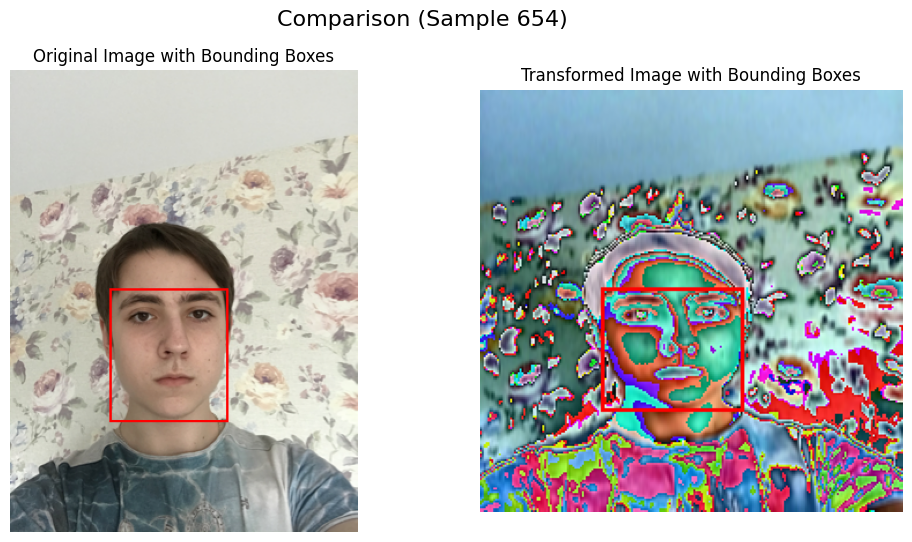

Original Image size: (400, 300), Transformed Image size: (224, 224)


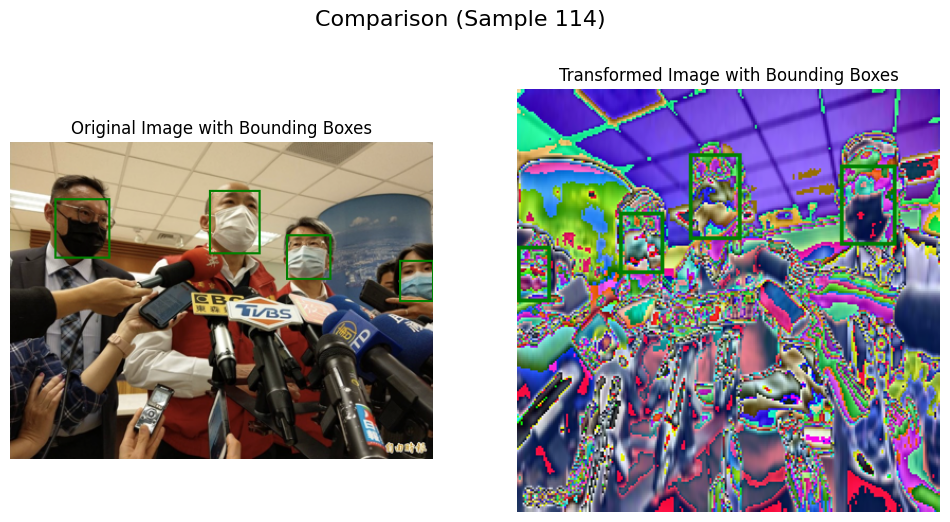

Original Image size: (400, 226), Transformed Image size: (224, 224)


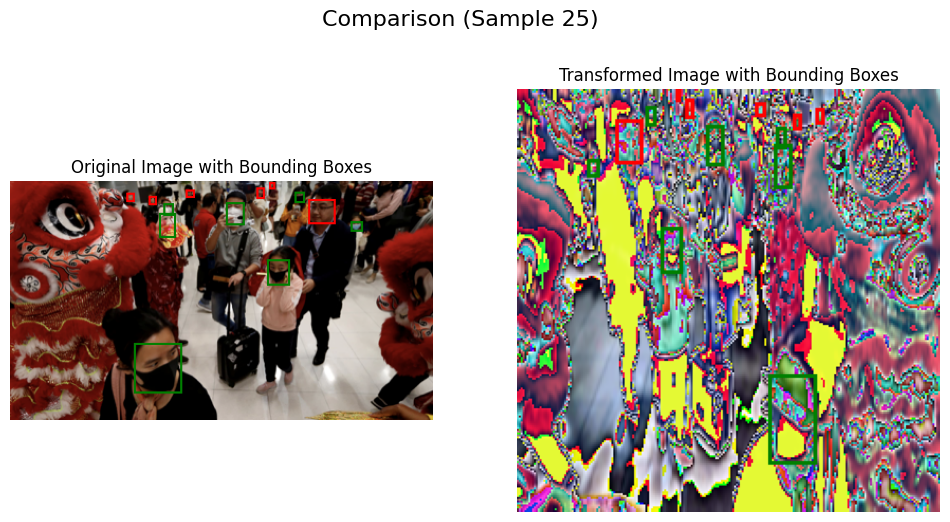

In [61]:
 # Function to plot and compare original and transformed images with annotations
def compare_transformed_image(dataset, n=3, seed=42):
  """
  Plots a series of random original and transformed images with their bounding boxes.

  Parameters:
    dataset (torch.utils.data.Dataset): The dataset to sample from.
    n (int, optional): Number of samples to plot. Defaults to 3.
    seed (int, optional): Random seed for the random generator. Defaults to 42.
  """
  random.seed(seed)
  random_indices = random.sample(range(len(dataset)), k=n) # Get random indices directly from the dataset

  # Define color based on label (example colors, you can customize)
  label_map = {0: "without_mask", 1: "with_mask", 2: "mask_weared_incorrect"} # Reverse mapping for plotting
  colors = {0: "red", 1: "green", 2: "orange"}


  for i in random_indices:
    # Get the original image path and annotation path from the dataset's file_pairs
    img_filename, annotation_filename = dataset.file_pairs[i]
    original_img_path = os.path.join(dataset.image_dir, img_filename)
    original_annotation_path = os.path.join(dataset.annotation_dir, annotation_filename)

    # Load original image and parse original annotation
    original_image = Image.open(original_img_path).convert("RGB")
    tree = ET.parse(original_annotation_path)
    root = tree.getroot()

    original_boxes = []
    original_labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        original_boxes.append([xmin, ymin, xmax, ymax])
        original_labels.append(label)

    original_target = {}
    original_target["boxes"] = torch.as_tensor(original_boxes, dtype=torch.float32)
    # Convert labels to integers for the original target as well for consistency
    label_to_int = {"without_mask": 0, "with_mask": 1, "mask_weared_incorrect": 2}
    original_target["labels"] = torch.as_tensor([label_to_int[label] for label in original_labels], dtype=torch.int64)


    # Get the transformed image and target from the dataset
    transformed_image, transformed_target = dataset[i]

    # Convert transformed image tensor to PIL Image for plotting
    transformed_image_pil = F.to_pil_image(transformed_image)

    # Create drawing objects
    draw_original = ImageDraw.Draw(original_image)
    draw_transformed = ImageDraw.Draw(transformed_image_pil)

    # Draw bounding boxes on original image
    for box, label in zip(original_target["boxes"], original_target["labels"]):
        xmin, ymin, xmax, ymax = box.tolist()
        color = colors.get(label.item(), "blue")
        draw_original.rectangle([(xmin, ymin), (xmax, ymax)], outline=color, width=2)

    # Draw bounding boxes on transformed image
    for box, label in zip(transformed_target["boxes"], transformed_target["labels"]):
        xmin, ymin, xmax, ymax = box.tolist()
        color = colors.get(label.item(), "blue")
        draw_transformed.rectangle([(xmin, ymin), (xmax, ymax)], outline=color, width=2)


    print(f"Original Image size: {original_image.size}, Transformed Image size: {transformed_image_pil.size}")
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original_image)
    axes[0].set_title("Original Image with Bounding Boxes")
    axes[0].axis("off")

    axes[1].imshow(transformed_image_pil)
    axes[1].set_title("Transformed Image with Bounding Boxes")
    axes[1].axis("off")

    plt.suptitle(f"Comparison (Sample {i})", fontsize=16)
    plt.show()


# Call the function with the training dataset
compare_transformed_image(dataset=train_dataset, n=3)

# 4. Create DataLoaders

Since our FaceMaskDatset function design to return a single sample from the datasets, for an object detection task, a single image sample consits of:

1. **An image tensor**: This is representing the images data, where after the transformation, it will have the specific shape( e.g. `[C, H, W]` for channels, heights and width).
2. **A target dictionary**: Since the datasets contain a *true lable*(the annotations), the dictionary will inclueds:
  * `"boxes"`: A tensor containing the bounding box coordinates that corresponding to the images. The shape would typically be `[N, 4]` where `N` is the number of object in that images and `4` represents the `[xmin, ymin, xmax, ymax]` coodinates of each box
  * `"label"`: A tensor containing the class label(e.g. 0 for "without mask", 1 for "with mask") for each corresponidng box, the shape should be `[N]`
  * `"image_id"`: A tensor containing a unique identifier for the images, it be use to keep track of what prediction belong to what original images
  * `"area"`: A tensor containing the area of each bounding box in the images. It is calculated as `(xmax-xmin)*(ymax-ymin). This can be usefull to filtering out the small or large details during training
  * `"iscrowd"`: A tensor indicating wherether the annotations box makes a crowd of object or a single object, typically a binary value for 0 or 1( False or True). And we treat all of this as individual obects for this case

----
Since this is object detection with custome datasets(e.g different size, annoations, box, labels, ...), we will be creating a custome `collate_fn`.

**What is `collate_fn`?**

  * In  `torch.utils.data.DataLoader` , `collate_fn` is responsible for telling the `DataLoaders` to take individual samples from the dataset and grouping them together to form batches.

  * The `collate_fn` function usually do it automatically in simple dataset(image classifcation) where the default `collate_fn` stacking tensors into batches (e.g stacking `[C, H, W]` tensor to get batch of shape of `[B, C, H, W]` where B is batch size)

However, since this is object dection class, there will be extra data like list of tuples and its annotations so we will need to build a custome `collate_fn`.

**What custom things can be in `collate_fn`**
  * It will receieve a list of tuples, one for eachh samples in batch and then need to:
    1. Combine the iamges tensor into batch of tensor
    2. Combine the target dictionaries into a format the your model can use.



In [62]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    """
    Custom collate function for object detection.

    Args:
        batch (list): A list of tuples, where each tuple contains
                     (image, target) from the dataset.

    Returns:
        tuple: A tuple containing a batch of images (as a list of tensors)
               and a batch of targets (as a list of dictionaries).
    """
    # The default collate_fn tries to stack tensors, which won't work for targets with varying numbers of bounding boxes.
    # Instead, we return lists of images and targets.
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

# Create DataLoaders using the custom collate_fn
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32, # You can adjust the batch size
    shuffle=True,
    num_workers=os.cpu_count(), # You can adjust the number of workers
    collate_fn=collate_fn
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16, # You can adjust the batch size
    shuffle=False, # No need to shuffle test data
    num_workers=os.cpu_count(), # You can adjust the number of workers
    collate_fn=collate_fn
)

print(f"Number of batches in training dataloader: {len(train_dataloader)}")
print(f"Number of batches in testing dataloader: {len(test_dataloader)}")

# Example of iterating through a batch
images, targets = next(iter(train_dataloader))
print("\nExample batch:")
print(f"Number of images in batch: {len(images)}")
print(f"Type of first image: {type(images[0])}")
print(f"Shape of first image: {images[0].shape}")
print(f"Number of targets in batch: {len(targets)}")
print(f"Type of first target: {type(targets[0])}")
print(f"Keys in first target dictionary: {targets[0].keys()}")

Number of batches in training dataloader: 22
Number of batches in testing dataloader: 11

Example batch:
Number of images in batch: 32
Type of first image: <class 'torch.Tensor'>
Shape of first image: torch.Size([3, 224, 224])
Number of targets in batch: 32
Type of first target: <class 'dict'>
Keys in first target dictionary: dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd'])




# 5. Define and train model

We will use YOLO(You Only Look Once) in this case because it is a very popular model for object detection task, and the pretrained model is already much help for us.

Since this is a small model that not required a lot of resources and power, we will be using [YOLOv8](https://docs.ultralytics.com/models/yolov8/)

## 5.1 Install all necessary library for YOLO

In [63]:
# Check if ultralytics is aleady install or not, if not then install
try:
  import ultralytics
except ImportError:
  print("Ultralytics is not installed. Installing...")
  !pip install ultralytics
  import ultralytics

## 5.1 Install all necessary library for YOLO

## 5.2 Load a pre-trained YOLOv8 model

In [64]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')

print("YOLOv8 model loaded successfully!")


YOLOv8 model loaded successfully!


### 5.3.1 Convert XML annotations to YOLO format

We need to convert the bounding box annotations from the XML format to the YOLO format. The YOLO format for a bounding box is `[class_id x_center y_center width height]`, where the coordinates are normalized to be between 0 and 1 relative to the image dimensions.

In [65]:
import os
import xml.etree.ElementTree as ET

def convert_xml_to_yolo(xml_filepath, img_width, img_height, class_map):
    """Converts a single XML annotation file to YOLO format."""
    tree = ET.parse(xml_filepath)
    root = tree.getroot()

    yolo_lines = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        if label in class_map:
            class_id = class_map[label]
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            # Calculate YOLO coordinates
            x_center = (xmin + xmax) / 2.0 / img_width
            y_center = (ymin + ymax) / 2.0 / img_height
            width = (xmax - xmin) / img_width
            height = (ymax - ymin) / img_height

            yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        else:
            print(f"Warning: Unknown label '{label}' found in {xml_filepath}. Skipping.")

    return yolo_lines

# Define the class mapping (should match the order in data.yaml)
class_map = {"without_mask": 0, "with_mask": 1, "mask_weared_incorrect": 2}

# Define input and output directories
train_annotations_dir = "dataset/train/annotations"
test_annotations_dir = "dataset/test/annotations"
train_images_dir = "dataset/train/images"
test_images_dir = "dataset/test/images"

train_labels_dir = "dataset/train/labels"
test_labels_dir = "dataset/test/labels"

# Create output directories if they don't exist
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)

# Process training annotations
print("Converting training annotations...")
for annotation_filename in os.listdir(train_annotations_dir):
    if annotation_filename.endswith(".xml"):
        xml_filepath = os.path.join(train_annotations_dir, annotation_filename)
        img_filename = os.path.splitext(annotation_filename)[0] + ".png" # Assuming image filename matches annotation filename
        img_filepath = os.path.join(train_images_dir, img_filename)

        try:
            # Get image dimensions to normalize bounding boxes
            from PIL import Image
            with Image.open(img_filepath) as img:
                img_width, img_height = img.size

            yolo_lines = convert_xml_to_yolo(xml_filepath, img_width, img_height, class_map)

            # Save YOLO annotations
            yolo_filename = os.path.splitext(annotation_filename)[0] + ".txt"
            yolo_filepath = os.path.join(train_labels_dir, yolo_filename)
            with open(yolo_filepath, "w") as f:
                f.write("\n".join(yolo_lines))

        except FileNotFoundError:
            print(f"Warning: Image file not found for annotation {annotation_filename}. Skipping.")
        except Exception as e:
            print(f"Error processing annotation {annotation_filename}: {e}")


# Process testing annotations
print("\nConverting testing annotations...")
for annotation_filename in os.listdir(test_annotations_dir):
    if annotation_filename.endswith(".xml"):
        xml_filepath = os.path.join(test_annotations_dir, annotation_filename)
        img_filename = os.path.splitext(annotation_filename)[0] + ".png" # Assuming image filename matches annotation filename
        img_filepath = os.path.join(test_images_dir, img_filename)

        try:
            # Get image dimensions to normalize bounding boxes
            from PIL import Image
            with Image.open(img_filepath) as img:
                img_width, img_height = img.size

            yolo_lines = convert_xml_to_yolo(xml_filepath, img_width, img_height, class_map)

            # Save YOLO annotations
            yolo_filename = os.path.splitext(annotation_filename)[0] + ".txt"
            yolo_filepath = os.path.join(test_labels_dir, yolo_filename)
            with open(yolo_filepath, "w") as f:
                f.write("\n".join(yolo_lines))

        except FileNotFoundError:
            print(f"Warning: Image file not found for annotation {annotation_filename}. Skipping.")
        except Exception as e:
            print(f"Error processing annotation {annotation_filename}: {e}")

print("\nAnnotation conversion complete.")

Converting training annotations...

Converting testing annotations...

Annotation conversion complete.


In [66]:
import yaml
import os

# Define the paths to your dataset directories
train_img_dir = "dataset/train/images"
train_ann_dir = "dataset/train/labels" # Updated to point to YOLO labels
val_img_dir = "dataset/test/images" # Using test set as validation for this example
val_ann_dir = "dataset/test/labels" # Updated to point to YOLO labels

# Define the class names
# Make sure the order matches the integer labels you defined in your FaceMaskDataset
class_names = ["without_mask", "with_mask", "mask_weared_incorrect"]
nc = len(class_names) # number of classes

# Create the data dictionary
data = {
    'train': train_img_dir,
    'val': val_img_dir,
    'nc': nc,
    'names': class_names
}

# Define the path to save the YAML file
yaml_file_path = "data.yaml"

# Write the data dictionary to the YAML file
with open(yaml_file_path, 'w') as f:
    yaml.dump(data, f, default_flow_style=None)

print(f"'{yaml_file_path}' created successfully with the following content:")
with open(yaml_file_path, 'r') as f:
    print(f.read())

'data.yaml' created successfully with the following content:
names: [without_mask, with_mask, mask_weared_incorrect]
nc: 3
train: dataset/train/images
val: dataset/test/images



## 5.3 Train the YOLOv8 model

In [67]:
# Train the model
# The 'data' argument specifies the path to your YAML file
results = model.train(data=yaml_file_path, epochs=10) # You can adjust the number of epochs

print("\nTraining finished!")

Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fal

train: Scanning /content/dataset/train/labels... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:00<00:00, 892.36it/s]

train: New cache created: /content/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1593.2±1072.8 MB/s, size: 423.7 KB)


val: Scanning /content/dataset/test/labels... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<00:00, 488.10it/s]

val: New cache created: /content/dataset/test/labels.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.58G      1.772      3.026      1.502         48        640: 100%|██████████| 43/43 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]


                   all        171        821    0.00939      0.379      0.126     0.0806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.58G      1.333      1.631      1.109         22        640: 100%|██████████| 43/43 [00:16<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


                   all        171        821      0.813      0.241      0.358      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.61G      1.291      1.408      1.093         60        640: 100%|██████████| 43/43 [00:16<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


                   all        171        821       0.43      0.521      0.452      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.62G       1.24      1.251      1.065         80        640: 100%|██████████| 43/43 [00:15<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]

                   all        171        821      0.541      0.518      0.529      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.63G      1.209      1.152       1.06         54        640: 100%|██████████| 43/43 [00:15<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        171        821      0.571      0.638      0.612      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.66G      1.196      1.037      1.056         25        640: 100%|██████████| 43/43 [00:16<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.74it/s]

                   all        171        821      0.891      0.588      0.663      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.68G       1.15     0.9688      1.027         30        640: 100%|██████████| 43/43 [00:16<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.21it/s]


                   all        171        821      0.851        0.6       0.68      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.69G      1.113     0.9119      1.015         25        640: 100%|██████████| 43/43 [00:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


                   all        171        821      0.836      0.606      0.714      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10       2.7G        1.1     0.8525      1.003         46        640: 100%|██████████| 43/43 [00:15<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

                   all        171        821      0.718      0.673      0.728      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.73G      1.063     0.8062     0.9868         61        640: 100%|██████████| 43/43 [00:15<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        171        821      0.748      0.686      0.751      0.514



10 epochs completed in 0.053 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]


                   all        171        821      0.724       0.72       0.75      0.513
          without_mask         61        143      0.769      0.813      0.853      0.546
             with_mask        154        656      0.848      0.947      0.965       0.66
 mask_weared_incorrect         18         22      0.556      0.399      0.432      0.334
Speed: 0.3ms preprocess, 3.5ms inference, 0.1ms loss, 6.3ms postprocess per image
Results saved to runs/detect/train3

Training finished!


## 6. Evaluate the Model

In [79]:
# Evaluate the model on the test set
metrics = model.val()

# Print the evaluation metrics
print("\nEvaluation Metrics:")
print(f"  mAP50-95(Avg acc): {metrics.results_dict['metrics/mAP50-95(B)']: .4f}")
print(f"  mAP50(Avg acc): {metrics.results_dict['metrics/mAP50(B)']: .4f}")

Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3352.9±815.3 MB/s, size: 498.4 KB)


val: Scanning /content/dataset/test/labels.cache... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.48it/s]


                   all        171        821      0.725      0.708      0.755      0.513
          without_mask         61        143      0.782      0.811      0.855      0.542
             with_mask        154        656      0.853       0.95      0.965      0.659
 mask_weared_incorrect         18         22      0.541      0.364      0.443      0.337
Speed: 1.7ms preprocess, 3.9ms inference, 0.1ms loss, 4.7ms postprocess per image
Results saved to runs/detect/train33

Evaluation Metrics:
  mAP50-95(Avg acc):  0.5127
  mAP50(Avg acc):  0.7545


## 7. Make Predictions


image 1/1 /content/dataset/test/images/maksssksksss251.png: 352x640 1 without_mask, 23 with_masks, 1 mask_weared_incorrect, 44.9ms
Speed: 2.7ms preprocess, 44.9ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)


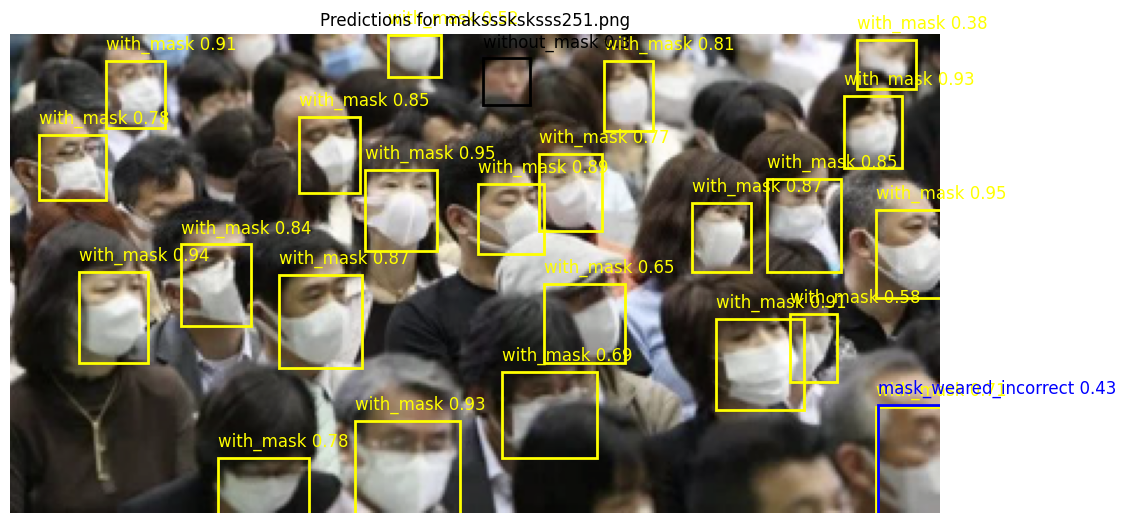


image 1/1 /content/dataset/test/images/maksssksksss296.png: 384x640 15 without_masks, 27 with_masks, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


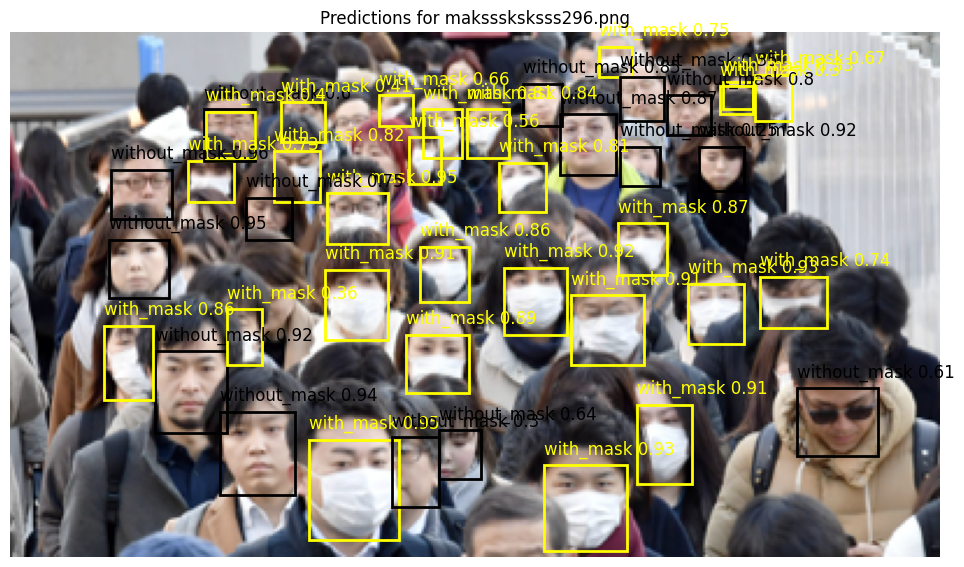


image 1/1 /content/dataset/test/images/maksssksksss379.png: 640x512 1 without_mask, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


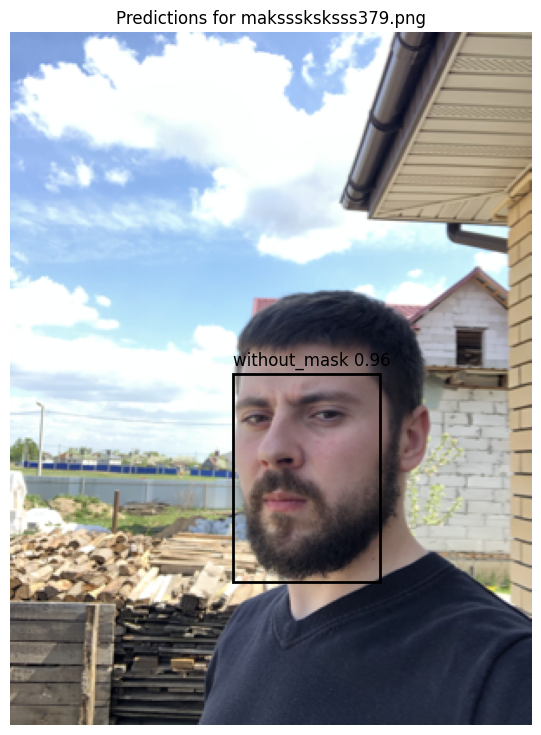


image 1/1 /content/dataset/test/images/maksssksksss725.png: 640x512 1 with_mask, 10.6ms
Speed: 4.6ms preprocess, 10.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 512)


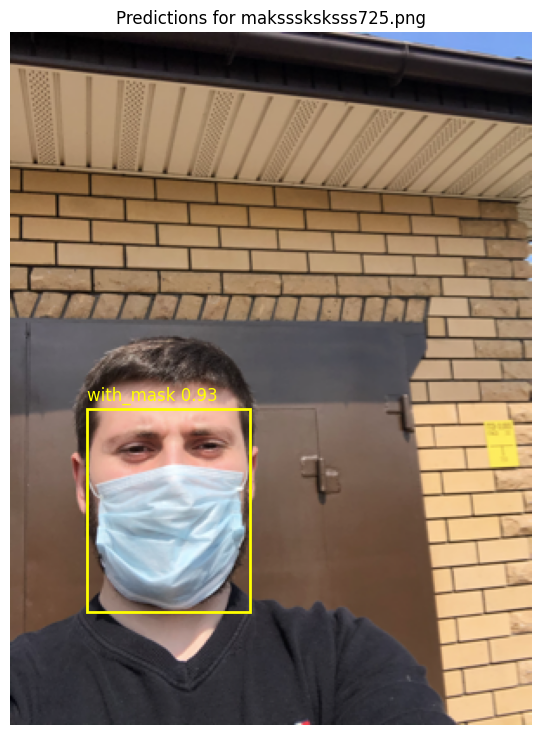


image 1/1 /content/dataset/test/images/maksssksksss234.png: 384x640 2 with_masks, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


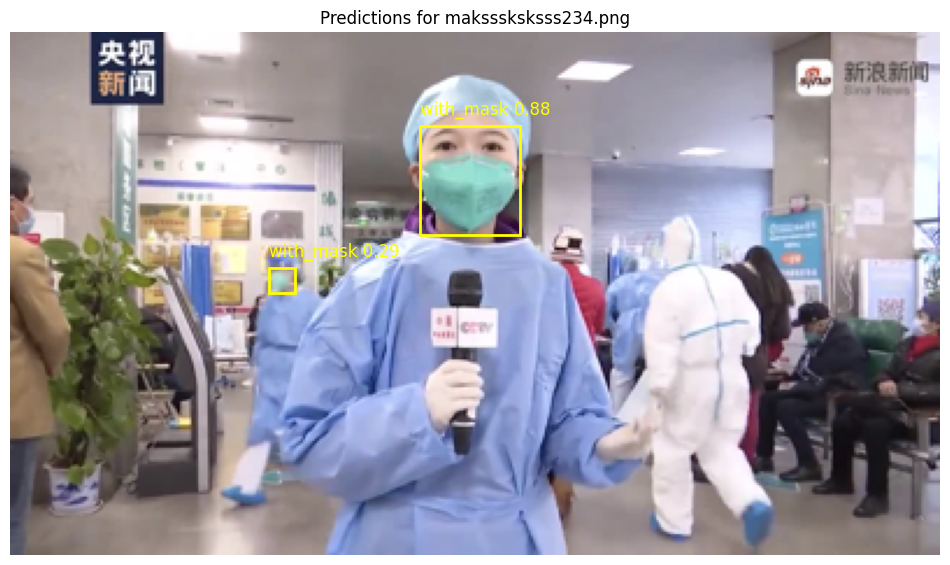

In [80]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import random # Import the random module

def predict_and_visualize(model, image_paths, class_names):
    """
    Uses the trained YOLOv8 model to predict objects in images and visualizes the results.

    Args:
        model (ultralytics.yolo.engine.model.YOLO): The trained YOLOv8 model.
        image_paths (list): A list of paths to the images for prediction.
        class_names (list): A list of class names in the order corresponding to the model's output.
    """
    for img_path in image_paths:
        try:
            # Perform inference
            results = model(img_path)

            # Load the image for visualization
            image = Image.open(img_path).convert("RGB")
            fig, ax = plt.subplots(1, figsize=(12, 9))
            ax.imshow(image)

            # Process results and draw bounding boxes
            for r in results:
                for box in r.boxes:
                    # Get box coordinates in original image size
                    xmin, ymin, xmax, ymax = [round(x) for x in box.xyxy[0].tolist()]
                    conf = round(box.conf[0].tolist(), 2)
                    cls = int(box.cls[0].tolist())
                    label = class_names[cls]

                    # Define color based on label
                    color = 'red' # Default color
                    if label == "with_mask":
                        color = "yellow"
                    elif label == "without_mask":
                        color = "black"
                    elif label == "mask_weared_incorrect":
                        color = "blue"


                    # Create a Rectangle patch
                    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                             linewidth=2, edgecolor=color, facecolor='none')

                    # Add the patch to the Axes
                    ax.add_patch(rect)

                    # Add label and confidence
                    plt.text(xmin, ymin - 5, f"{label} {conf}", color=color, fontsize=12)

            ax.axis('off')
            plt.title(f"Predictions for {os.path.basename(img_path)}")
            plt.show()

        except FileNotFoundError:
            print(f"Error: Image file not found at {img_path}")
        except Exception as e:
            print(f"An error occurred while processing {img_path}: {e}")

# Example usage:
# Define the directory containing the test images
test_images_dir = "dataset/test/images"

# List all files in the test images directory
all_test_image_filenames = [f for f in os.listdir(test_images_dir) if f.endswith((".png", ".jpg", ".jpeg"))] # Added common image extensions

# Select a random sample of filenames from the list
num_example_images = 5 # Number of random images to select
if len(all_test_image_filenames) > 0:
    random_image_filenames = random.sample(all_test_image_filenames, min(num_example_images, len(all_test_image_filenames)))
else:
    random_image_filenames = []
    print(f"No image files found in {test_images_dir}")

# Construct the full paths for the selected random images
example_image_paths = [os.path.join(test_images_dir, filename) for filename in random_image_filenames]


# Use the trained model and the class names defined earlier
predict_and_visualize(model, example_image_paths, class_names)